In [1]:
import cv2
import SUNRGBD
import random as rand
import pandas as pd
import numpy as np
import json
import os
import shutil
import sys
import h5py
import scipy.io

In [3]:
path_to_sun = "./../../SUNRGBD/"

In [2]:
%pwd

'/Users/evinpinar/Documents/Classes/THESIS/planercnn/sun'

In [4]:
store = []
for f in os.listdir(path_to_sun):
    if not f.startswith('.'):
        store.append(f)
        
b = []
for i in range(len(store)):
    for f in os.listdir(path_to_sun + store[i]):
        if not f.startswith('.'):
            b.append(path_to_sun + store[i] + "/" + f + "/")
store = []

c = []
for i in range(len(b)):
    if b[i] != (path_to_sun + "xtion/sun3ddata/"):
        for f in os.listdir(b[i]):
            if not f.startswith('.'):
                store.append(b[i]  + f + "/")
    else:
        for f in os.listdir(b[i]):
            if not f.startswith('.'):
                c.append(b[i]  + f + "/")

In [5]:
for i in range(len(c)):
    for f in os.listdir(c[i]):
        if not f.startswith('.'):
            for r in os.listdir(c[i]  + f + "/"):
                if not r.startswith('.'):
                    store.append(c[i]  + f + "/" + r + "/")

In [6]:
#just excluded
#'/Users/ekaterina/Desktop/diploma/mask_rcnn/datasets/SUNRGBD/kv2/kinect2data/000667_2014-06-09_21-06-12_260595134347_rgbf000145-resize/'
#checking that we collected all the pictures
len(store)

10335

In [7]:
#The standdard trainval-test split uses the first 5050 images for testing and the rest for trainval.
if not os.path.exists((path_to_sun + "test") or (path_to_sun + "train")):
    os.makedirs(path_to_sun + "test")
    os.makedirs(path_to_sun + "train")
if not os.path.exists((path_to_sun + "train" + "/train") or (path_to_sun + "train"+ "/val")):
    os.makedirs(path_to_sun + "train" + "/train")
    os.makedirs(path_to_sun + "train"+ "/val")

# Work with a class mapping

In [8]:
import pandas as pd
import scipy.io

mat = scipy.io.loadmat('classMapping40.mat')

label_13 = [1,2,3,4,5,6,7,8,9,10,11,12,13]
name_13 = ["bed", "books", "ceiling", 
                 "chair", "floor", "furniture", 
                 "objects", "picture", "sofa", 
                 "table", "tv", "wall", "window"]

labels_13 = pd.DataFrame({
     'label_13': label_13,
     'name_13': name_13})

In [9]:
list_of_40 = []
for i in range(0, len(mat["className"][0])):
    list_of_40.append(mat["className"][0][i][0]) 
    
label_of_40 = list(range(1,41))
merging = [12,5,6,1,4,9,10,12,13,6,8,6,13,10,6,13,6,7,7,5,7,3,2,6,11,7,7,7,7,7,7,6,7,7,7,7,7,7,6,7]

labels_40 = pd.DataFrame({
     'Label_40': label_of_40,
     'Name_40': list_of_40,
     "label_13": merging})

In [9]:
allClassName_894 = []
for i in range(0, len(mat["allClassName"][0])):
    allClassName_894.append(mat["allClassName"][0][i][0])

mapClass_894 = []
for i in range(0, len(mat["mapClass"][0])):
    mapClass_894.append(mat["mapClass"][0][i])
    
labels_894 = pd.DataFrame({
     'Label_40': list(mapClass_894),
     'Name_894': list(allClassName_894)})

In [10]:
df = pd.read_csv('name_mapping_from_toolbox')
df = df.drop(['Unnamed: 0'], axis=1)
df = pd.merge(df, labels_40, left_on="Label_37", right_on="Label_40").drop([ 'Label_37', 'Name_37'], axis=1)

In [11]:
print(labels_894.loc[labels_894['Name_894'] == 'book'])
df3 = pd.merge(labels_894, labels_40)
final_dataset = pd.merge(df3, labels_13)

   Label_40 Name_894
0        40     book


In [12]:
labels_needed = {}
#Converting data to work with 13 classes
for i in range(0, len(df)):
    labels_needed[str(df.iloc[i]['Name_6585'])] = df.iloc[i]['label_13']
    
# Adding data for the dun from matlab file
#Converting data to work with 13 classes
for i in range(0, len(final_dataset)):
    labels_needed[str(final_dataset.iloc[i]['Name_894'])] = final_dataset.iloc[i]['label_13']

# Start the parsing

In [13]:
all_labels = []
for key in labels_needed.keys():
    all_labels.append(key)

In [14]:
import stringdist

ufo = {}
def transformation(image_root, number_of_image):
    # Set the paths
    image_root = image_root
    path_to_image = image_root + "image/" + (os.listdir(image_root + "/image/")[0])
    anotation = image_root + 'annotation2Dfinal'
    
    with open(anotation + "/index.json") as data_file:
        data = json.load(data_file)
    
    numberOfAnot = len(data["frames"][0]["polygon"])
    element = {}

    size =  os.path.getsize(path_to_image)
    filename = os.listdir(image_root + "/image")
    filename = filename[0]

    element = {"fileref": '', "size": size, 
        "filename": str(number_of_image) + ".jpg", 'base64_img_data': '', 'file_attributes': {}, 'regions': {}}
    
    anootation2D = []
    labels2D = []
    regions = {}
    
    for i in range(0, numberOfAnot):
        x = data["frames"][0]["polygon"][i]["x"]
        y = data["frames"][0]["polygon"][i]["y"]
        idxObj = data["frames"][0]["polygon"][i]["object"]
        if idxObj <= len(data['objects']):
            label = data['objects'][idxObj]["name"].lower()
            label = ''.join(i for i in label if not i.isdigit())
            if label in labels_needed:
                label = labels_needed[label]
            else:
                leve = {}
                for i in range(0,len(all_labels)):
                    leve[all_labels[i]] = stringdist.levenshtein(label, all_labels[i])
                label = labels_needed[min(leve, key=leve.get)]
                ufo[min(leve, key=leve.get)] = label
            if type(x) == list and type(y) == list:
                all_points_x = list(map(round, x))
                all_points_y = list(map(round, y))
                if len(all_points_y) != 0 and len(all_points_x) != 0:
                    shape_attributes = {'name':'polygon',"all_points_x":x,"all_points_y":y}
                    region = {'shape_attributes': {'name': 'polygon',
                    'all_points_x': x, 'all_points_y': y}, 'region_attributes': {"class": int(label)}}  
                    element['regions'][str(i)] = region
    return element

In [15]:
# For the NYU dataset
# 80% of train images - 1160 pics (0, 1160)
   # 10% test - 145 pics (1160,1305)
   # 10: validation - 144 pics (1305, 1449)
# 20% of test images - 289

# 5050 test images store[0 : 5049]
# 5285 train-val images [5050 : 10334]
   # 4226 train images [5050:9275]
   # 1056 validation images [9276: 10333]
d = {}
fail = []
# Working with a test dataset - 5050 images
for i in range(0, 1160):
    try:
        element2 = {}
        number_of_image = i
        print(number_of_image)
        element2 = transformation(store[i], number_of_image)
    #except json.decoder.JSONDecodeError:
    except ValueError:
        print("Fuckup with " + store[i])
        fail.append(store[i])
    #print(element2)
    if element2:
        file_name = os.listdir(store[i] + "/image")[0]
        file_to_copy = store[i] + "image/" + file_name
        target_dir = path_to_sun + "train/train/"
        shutil.copyfile(file_to_copy, target_dir + str(i) + ".jpg")
        d[str(i) + ".jpg" + str(os.path.getsize(file_to_copy))] = element2

jsonname2 =  path_to_sun + "train/train/" + "via_region_data.json"
with open(jsonname2, 'w') as fp:
        json.dump(d, fp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [16]:
print("Pictures failed:" + str(len(fail)))
print("Pictures parsed:" + str(len(d)))

Pictures failed:0
Pictures parsed:1160


In [17]:
ufo

{'air conditioner': 7,
 'air duct': 7,
 'air vent': 7,
 'aluminium foil': 7,
 'american flag': 7,
 'baby gate': 7,
 'back scrubber': 7,
 'baking dish': 7,
 'banana peel': 7,
 'basketball hoop': 7,
 'bedding package': 7,
 'bicycle helmet': 7,
 'binder': 7,
 'book': 7,
 'book holder': 7,
 'bottle of comet': 7,
 'bottle of liquid': 7,
 'bottle of listerine': 7,
 'bottle of perfume': 7,
 'bottle of soap': 7,
 'bread': 7,
 'business cards': 7,
 'cable modem': 7,
 'cables': 7,
 'can of food': 7,
 'can opener': 7,
 'cap stand': 7,
 'cardboard sheet': 7,
 'cardboard tube': 7,
 'carton': 7,
 'casserole dish': 7,
 'cat cage': 6,
 'cat house': 7,
 'cd disc': 7,
 'cell phone': 7,
 'cell phone charger': 7,
 'chair': 4,
 'charger and wire': 7,
 'chart roll': 7,
 'chart stand': 6,
 'child carrier': 7,
 'cleaning wipes': 7,
 'clothing detergent': 7,
 'clothing dryer': 6,
 'clothing hamper': 6,
 'clothing iron': 7,
 'clothing washer': 6,
 'coat hanger': 7,
 'coffee grinder': 7,
 'coffee machine': 7,
 '

In [18]:
d2 = {}
fail2 = []
# Working with a train dataset - 4226 images
for i in range(1160,1305):
    try:
        element2 = {}
        number_of_image = i
        print(number_of_image)
        element2 = transformation(store[i], number_of_image)
        #print(element2)
        if element2:
            file_name = os.listdir(store[i] + "/image")[0]
            file_to_copy = store[i] + "image/" + file_name
            target_dir = path_to_sun + "test/"
            shutil.copyfile(file_to_copy, target_dir + str(i) + ".jpg")
            d2[str(i) + ".jpg" + str(os.path.getsize(file_to_copy))] = element2
    #except json.decoder.JSONDecodeError:
    except ValueError:
        print("Fuckup with " + store[i])
        fail2.append(store[i])

jsonname2 =  path_to_sun + "test/" + "via_region_data.json"
with open(jsonname2, 'w') as fp:
        json.dump(d2, fp)

1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304


In [19]:
print("Pictures failed:" + str(len(fail2)))
print("Pictures parsed:" + str(len(d2)))

Pictures failed:0
Pictures parsed:145


In [20]:
d3 = {}
fail3 = []
# Working with a train dataset - 4226 images
for i in range(1305, 1449):
    try:
        element2 = {}
        number_of_image = i
        print(number_of_image)
        element2 = transformation(store[i], number_of_image)
    except json.decoder.JSONDecodeError:
        print("Fuckup with " + store[i])
        fail3.append(store[i])
    #print(element2)
    if element2:
        file_name = os.listdir(store[i] + "/image")[0]
        file_to_copy = store[i] + "image/" + file_name
        target_dir = path_to_sun + "train/val/"
        shutil.copyfile(file_to_copy, target_dir + str(i) + ".jpg")
        d3[str(i) + ".jpg" + str(os.path.getsize(file_to_copy))] = element2

jsonname2 =  path_to_sun + "train/val/" + "via_region_data.json"
with open(jsonname2, 'w') as fp:
        json.dump(d3, fp)

1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448


In [21]:
print("Pictures failed:" + str(len(fail3)))
print("Pictures parsed:" + str(len(d3)))

Pictures failed:0
Pictures parsed:144


In [22]:
image_root = store[100]

In [23]:
frameData = SUNRGBD.readFrame(image_root, True )

In [24]:
import matplotlib.pyplot as plt
imgRGBWithAnnotations = np.array(frameData.imgRGB, copy=True)

for i in range(0, len(frameData.annotation2D)):
    color = [rand.randint(0,255), rand.randint(0,255), rand.randint(0,255)]
    cv2.fillPoly(imgRGBWithAnnotations, [frameData.annotation2D[i]], color)
    
for i in range(0, len(frameData.annotation2D)):
    data = frameData.annotation2D[i];
    centroid = np.mean(data,axis=0)
    cv2.putText(imgRGBWithAnnotations, frameData.labels2D[i], (int(centroid[0]), int(centroid[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.7, [0,0,0],2)
    

In [25]:
data = frameData.annotation2D
data2 = frameData.labels2D

In [26]:
anotation2D = image_root + "/annotation2Dfinal/index.json"

with open(anotation2D) as data_file:    
    data = json.load(data_file)

    numberOfAnot = len(data["frames"][0]["polygon"]);
    anootation2D = [];
    labels2D = [];
    for i in range(0,numberOfAnot):
        x = data["frames"][0]["polygon"][i]["x"]
        y = data["frames"][0]["polygon"][i]["y"]

        idxObj = data["frames"][0]["polygon"][i]["object"];
        pts2 = np.array([x,y], np.int32)
        pts2 = np.transpose(pts2);
        anootation2D.append(pts2);
        labels2D.append(data['objects'][idxObj]["name"])

Depth data


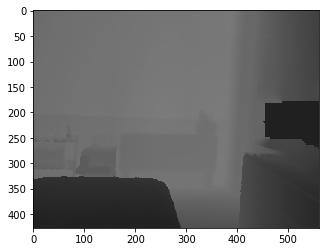

In [27]:
print("Depth data")
plt.imshow(frameData.imgD);

RGB Image


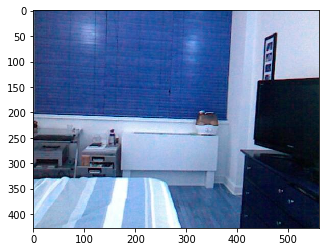

In [28]:
print("RGB Image")
plt.imshow(frameData.imgRGB);

Annotated Image


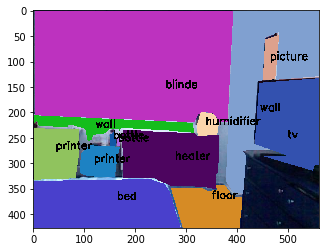

In [29]:
print("Annotated Image")
plt.imshow(imgRGBWithAnnotations);